In [3]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from glob import glob

2024-08-11 02:59:39.345261: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-11 02:59:39.345360: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-11 02:59:39.510499: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
dataset_directory = '/kaggle/input/hardata/HARDATA_SHREYA'
img_height = 224
img_width = 224
batch_size = 32
num_classes = len(glob(dataset_directory + "/*"))

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Reserve 20% of data for validation
)

In [6]:
train_generator = train_datagen.flow_from_directory(
    dataset_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 4359 images belonging to 25 classes.


In [7]:
validation_generator = train_datagen.flow_from_directory(
    dataset_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 1078 images belonging to 25 classes.


In [8]:
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

In [9]:
vgg = VGG16(input_shape=(img_height, img_width, 3), weights='imagenet', include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
x = vgg.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)  # Batch Normalization layer
x = tf.keras.layers.Dropout(0.5)(x)  # Dropout layer
x = tf.keras.layers.Dense(256, activation='relu')(x)  # Increased complexity with additional dense layer
x = tf.keras.layers.BatchNormalization()(x)  # Batch Normalization layer
x = tf.keras.layers.Dropout(0.5)(x)  # Dropout layer
prediction = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

In [11]:
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 27,701,081 (105.67 MB)

 Trainable params: 27,699,545 (105.67 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [12]:
for layer in vgg.layers:
    layer.trainable = False

In [13]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-4)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

In [15]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/136 ━━━━━━━━━━━━━━━━━━━━ 1:27:43 39s/step - accuracy: 0.0312 - loss: 4.8438

I0000 00:00:1723345232.950046     129 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723345232.976708     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 11/136 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - accuracy: 0.0370 - loss: 4.7637  

W0000 00:00:1723345249.749800     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.0518 - loss: 4.4729

W0000 00:00:1723345312.388164     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


136/136 ━━━━━━━━━━━━━━━━━━━━ 135s 711ms/step - accuracy: 0.0519 - loss: 4.4716 - val_accuracy: 0.1278 - val_loss: 3.1249
Epoch 2/50
  1/136 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - accuracy: 0.0312 - loss: 4.5235

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
W0000 00:00:1723345352.799278     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


136/136 ━━━━━━━━━━━━━━━━━━━━ 25s 184ms/step - accuracy: 0.0312 - loss: 4.5235 - val_accuracy: 0.1818 - val_loss: 3.2265
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 65s 457ms/step - accuracy: 0.1152 - loss: 3.8862 - val_accuracy: 0.1733 - val_loss: 2.9342
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0625 - loss: 3.4128 - val_accuracy: 0.1364 - val_loss: 2.9026
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 65s 461ms/step - accuracy: 0.1259 - loss: 3.6792 - val_accuracy: 0.2320 - val_loss: 2.7678
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.1562 - loss: 3.6036 - val_accuracy: 0.1364 - val_loss: 3.0669
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 64s 454ms/step - accuracy: 0.1512 - loss: 3.4874 - val_accuracy: 0.1989 - val_loss: 2.8220
Epoch 8/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0938 - loss: 3.6123 - val_accuracy: 0.3182 - val_loss: 2.7211
Epoch 9/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 64s 452ms/step - accuracy: 0.1724 - loss: 3.3491 - val_accur

In [16]:
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation accuracy: {accuracy:.4f}, Validation loss: {loss:.4f}')

34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 372ms/step - accuracy: 0.2259 - loss: 2.7009
Validation accuracy: 0.2236, Validation loss: 2.7189


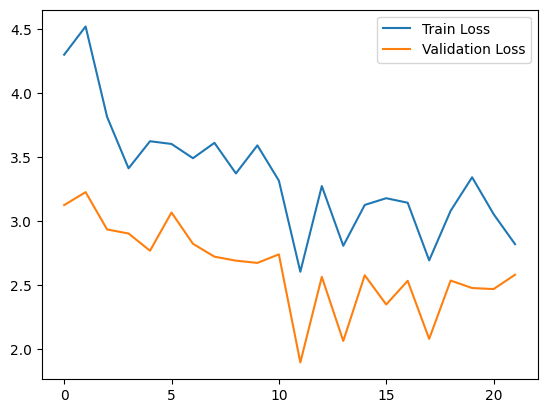

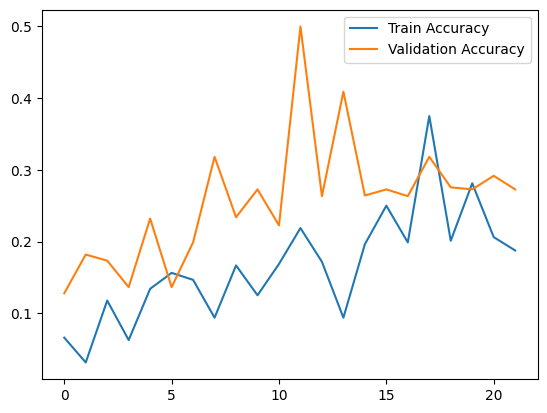

In [17]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [18]:
def plot_predictions(model, generator, class_names):
    images, labels = next(generator)
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[true_classes[i]]}\nPred: {class_names[predicted_classes[i]]}")
        plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step


W0000 00:00:1723346028.165596     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


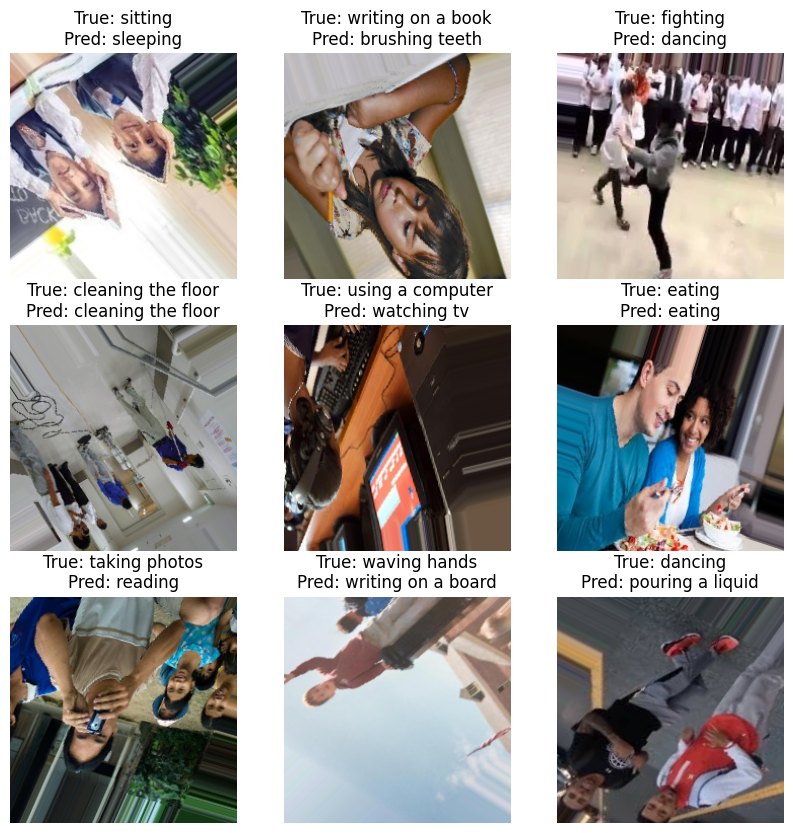

In [19]:
class_names = list(train_generator.class_indices.keys())
plot_predictions(model, validation_generator, class_names)

In [20]:
# Step 14: Save the Final Model
model.save('facefeatures_new_model.h5')

Found 1078 images belonging to 25 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 364ms/step


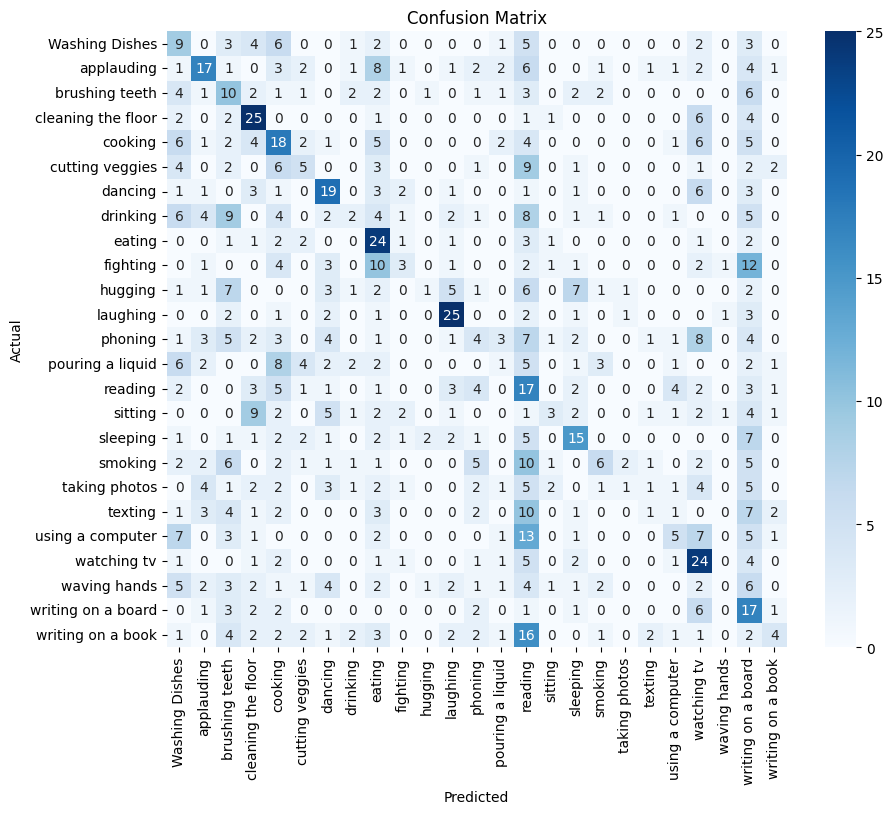

                    precision    recall  f1-score   support

    Washing Dishes       0.15      0.25      0.19        36
        applauding       0.40      0.31      0.35        55
    brushing teeth       0.14      0.26      0.19        39
cleaning the floor       0.38      0.60      0.47        42
           cooking       0.23      0.32      0.26        57
   cutting veggies       0.22      0.14      0.17        36
           dancing       0.37      0.45      0.40        42
          drinking       0.14      0.04      0.06        51
            eating       0.28      0.62      0.38        39
          fighting       0.23      0.07      0.11        41
           hugging       0.20      0.03      0.05        39
          laughing       0.53      0.64      0.58        39
           phoning       0.13      0.08      0.10        51
  pouring a liquid       0.07      0.03      0.04        40
           reading       0.11      0.35      0.17        49
           sitting       0.27      0.08

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Reset the generator before prediction
validation_generator = train_datagen.flow_from_directory(
    dataset_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Generate predictions
predictions = model.predict(validation_generator, steps=len(validation_generator))

# Convert predictions classes to one-hot encoding
predicted_classes = np.argmax(predictions, axis=1)

# True classes
true_classes = validation_generator.classes

# Class labels
class_labels = list(validation_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))
